In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 40em; }</style>"))

In [2]:
from os import sys, path
sys.path.append('D:/Elsy/Development/PycharmProjects/elsy_analytics/')
import analytic_functions.bayesian_stan_mmm as bmmm
import warnings
warnings.filterwarnings("ignore")
import pystan
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.feature_selection import ExhaustiveFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
import numpy as np
import pandas as pd
import math
import json
import pickle
import sys
import time
from hpd import hpd_grid
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

sns.color_palette("husl")
sns.set_style('darkgrid')

import plotly.io as pio
# pio.renderers.default = "browser"


INFO:numexpr.utils:NumExpr defaulting to 8 threads.


### DATA

In [3]:
my_path = 'D:/Elsy/Product/Test/bayesian_mmm/'
df = pd.read_excel('{0}/{1}'.format(my_path, 'data/elsy_dataset_v1_TotalNike.xlsx'), sheet_name='elsy_dataset_v1')
df = df[df['date'] <= '2020-11-23']


model_params = {
    'ModelName': 'bayesian_linear_model_mmm_nike_time_series',
    'ModelForm': 'linear',  # linear / log-log
    'DependentVariable': 'exisiting_member_sales',
    'MediaVariables': {
        'MediaQuantity': ['paid_search_clicks', 'online_media_impressions', 'paid_social_impressions'],
        'MediaSpend': ['paid_search_spend', 'online_media_spend', 'paid_social_spend'],
        'Transformation': {
            'DiminishingFunction': 'power',
            'DecayFunction': 'geometric'
        }
    },
    'CompetitiveMediaVariables': {
        'MediaQuantity': ['adidas_impressions', 'vans_impressions', 'converse_impressions', 'ua_impressions', 'reebok_impressions', 'lulu_impressions', 'champion_impressions', 'puma_impressions', 'nb_impressions', 'fila_impressions', 'asics_impressions', 'brooks_impressions', 'athleta_impressions', 'fitbit_impressions', 'hokaone_impressions', 'lecoqsportif_impressions', 'onrunning_impressions', 'nocta_impressions'],
        'Transformation': {
            'DiminishingFunction': 'power',
            'DecayFunction': 'geometric'
        }
    },
    'ControlVariables': {
        'Positive': ['active_stores', 'D_BASEBALL_D', 'D_BASKETBALL_D', 'D_GOLF_D', 'D_MARATHON_D', 'D_OLYMPICS_D', 'D_SOCCER_D', 'D_TENNIS_D', 'D_H_AMZ_PRM_FLG', 'D_H_BLKFRI_FLG', 'D_H_CINCO_DE_MAYO_FLG', 'D_H_COL_FLG', 'D_H_DAD_FLG', 'D_H_EAST_FLG', 'D_H_ELECTION_FLG', 'D_H_GDFRI_FLG', 'D_H_HALL_FLG', 'D_H_IND_FLG', 'D_H_LABOR_FLG', 'D_H_MEM_FLG', 'D_H_MOM_FLG', 'D_H_OLYMP_FLG', 'D_H_OLYMP_BEG_FLG', 'D_H_STPAT_FLG', 'D_H_THANK_FLG', 'D_H_THANK_LD1_FLG', 'D_H_VET_FLG'],
        'Neutral': ['D_DTN_M3', 'D_DTN_M4', 'D_DTN_M5', 'D_DTN_M6', 'D_DTN_M7', 'D_DTN_M8', 'D_DTN_M9', 'D_DTN_M10', 'D_DTN_M11'],
        'Negative': ['CPI', 'unem_rate']
    },
    'Date': 'date',
    'CrossSection': None
}


In [4]:
# Model Properties
model_name = model_params['ModelName']
model_form = model_params['ModelForm']

# Dependent Variable
dep_var = model_params['DependentVariable']

# Media Variables
media_vars = model_params['MediaVariables']['MediaQuantity']
media_spend_columns = model_params['MediaVariables']['MediaSpend']

# Competitive Media Variables
comp_media_vars = model_params['CompetitiveMediaVariables']['MediaQuantity']

# Control Variables
positive_vars = model_params['ControlVariables']['Positive']
neutral_vars = model_params['ControlVariables']['Neutral']
negative_vars = model_params['ControlVariables']['Negative']

# Cross Section / Date
cross_section_col = model_params['CrossSection'] if 'CrossSection' in model_params.keys() else None
date_col = model_params['Date']
df = bmmm.set_df_index(df, date_col, cross_section_col)

# Spend data frame
df_media_spend = df[media_spend_columns].copy()
df_media_spend.index = df.index
df_media_spend = df_media_spend.rename(columns={col: bmmm.shorten_name(col) for col in df_media_spend.columns})


### EDA

<AxesSubplot:ylabel='Channel'>

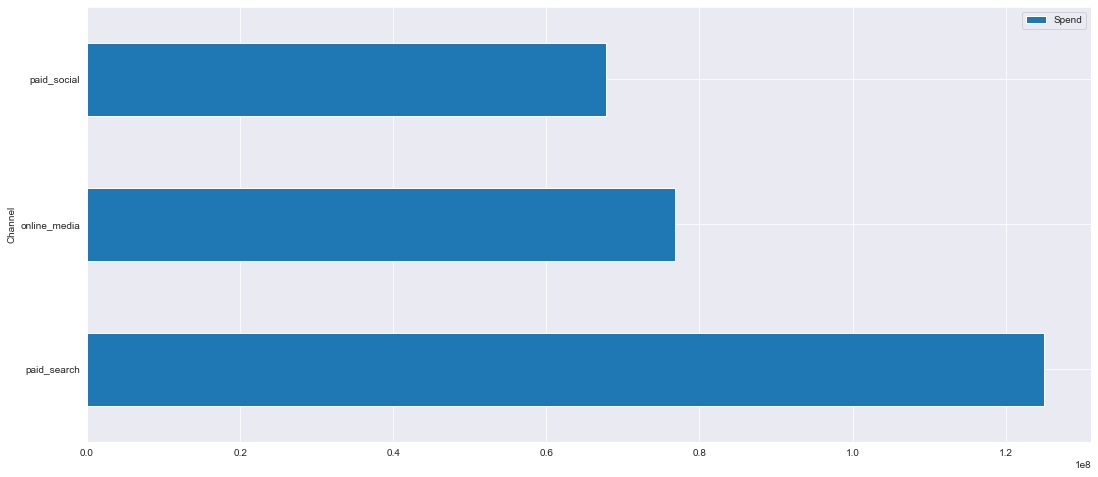

In [5]:
df_media_spend_summary = pd.DataFrame([{'Channel': channel, 'Spend': sum(df_media_spend[channel])} for channel in df_media_spend.columns]).sort_values('Spend', ascending=[0])
df_media_spend_summary.index = df_media_spend_summary['Channel']
df_media_spend_summary.plot(kind='barh', figsize=(18, 8))

<AxesSubplot:>

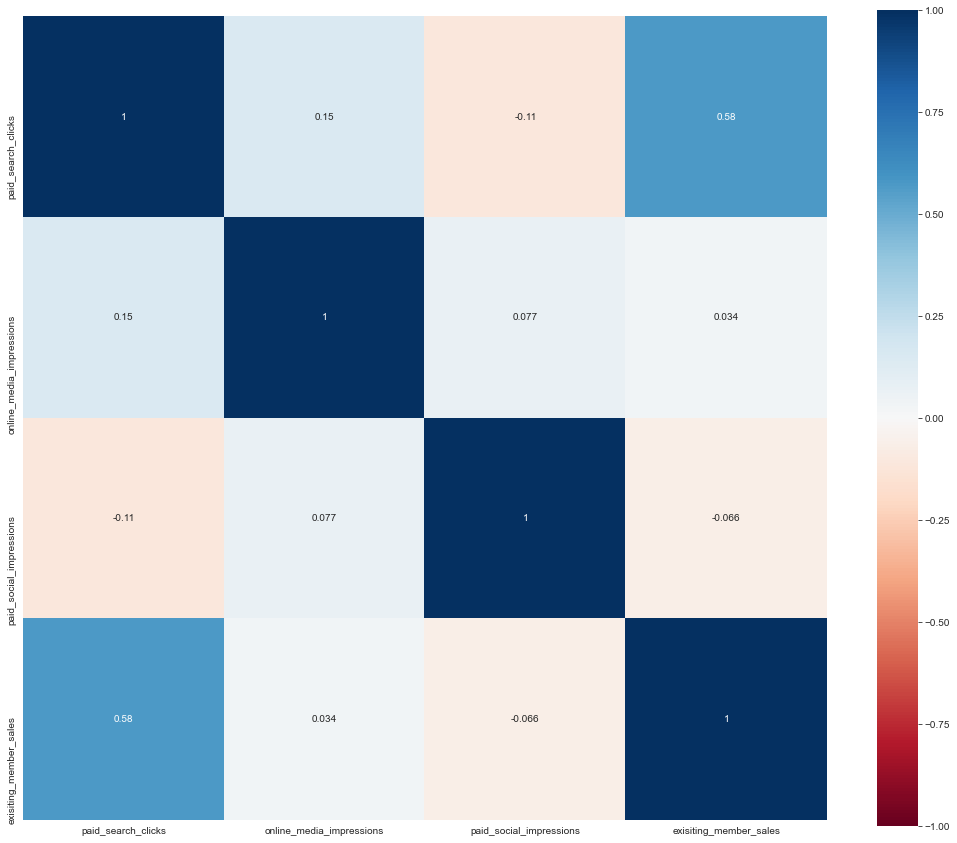

In [6]:
df_correlation = df[media_vars + [dep_var]].corr()
plt.figure(figsize=(18, 15))
sns.heatmap(df_correlation, square=True, annot=True, vmax=1, vmin=-1, cmap='RdBu')

<AxesSubplot:>

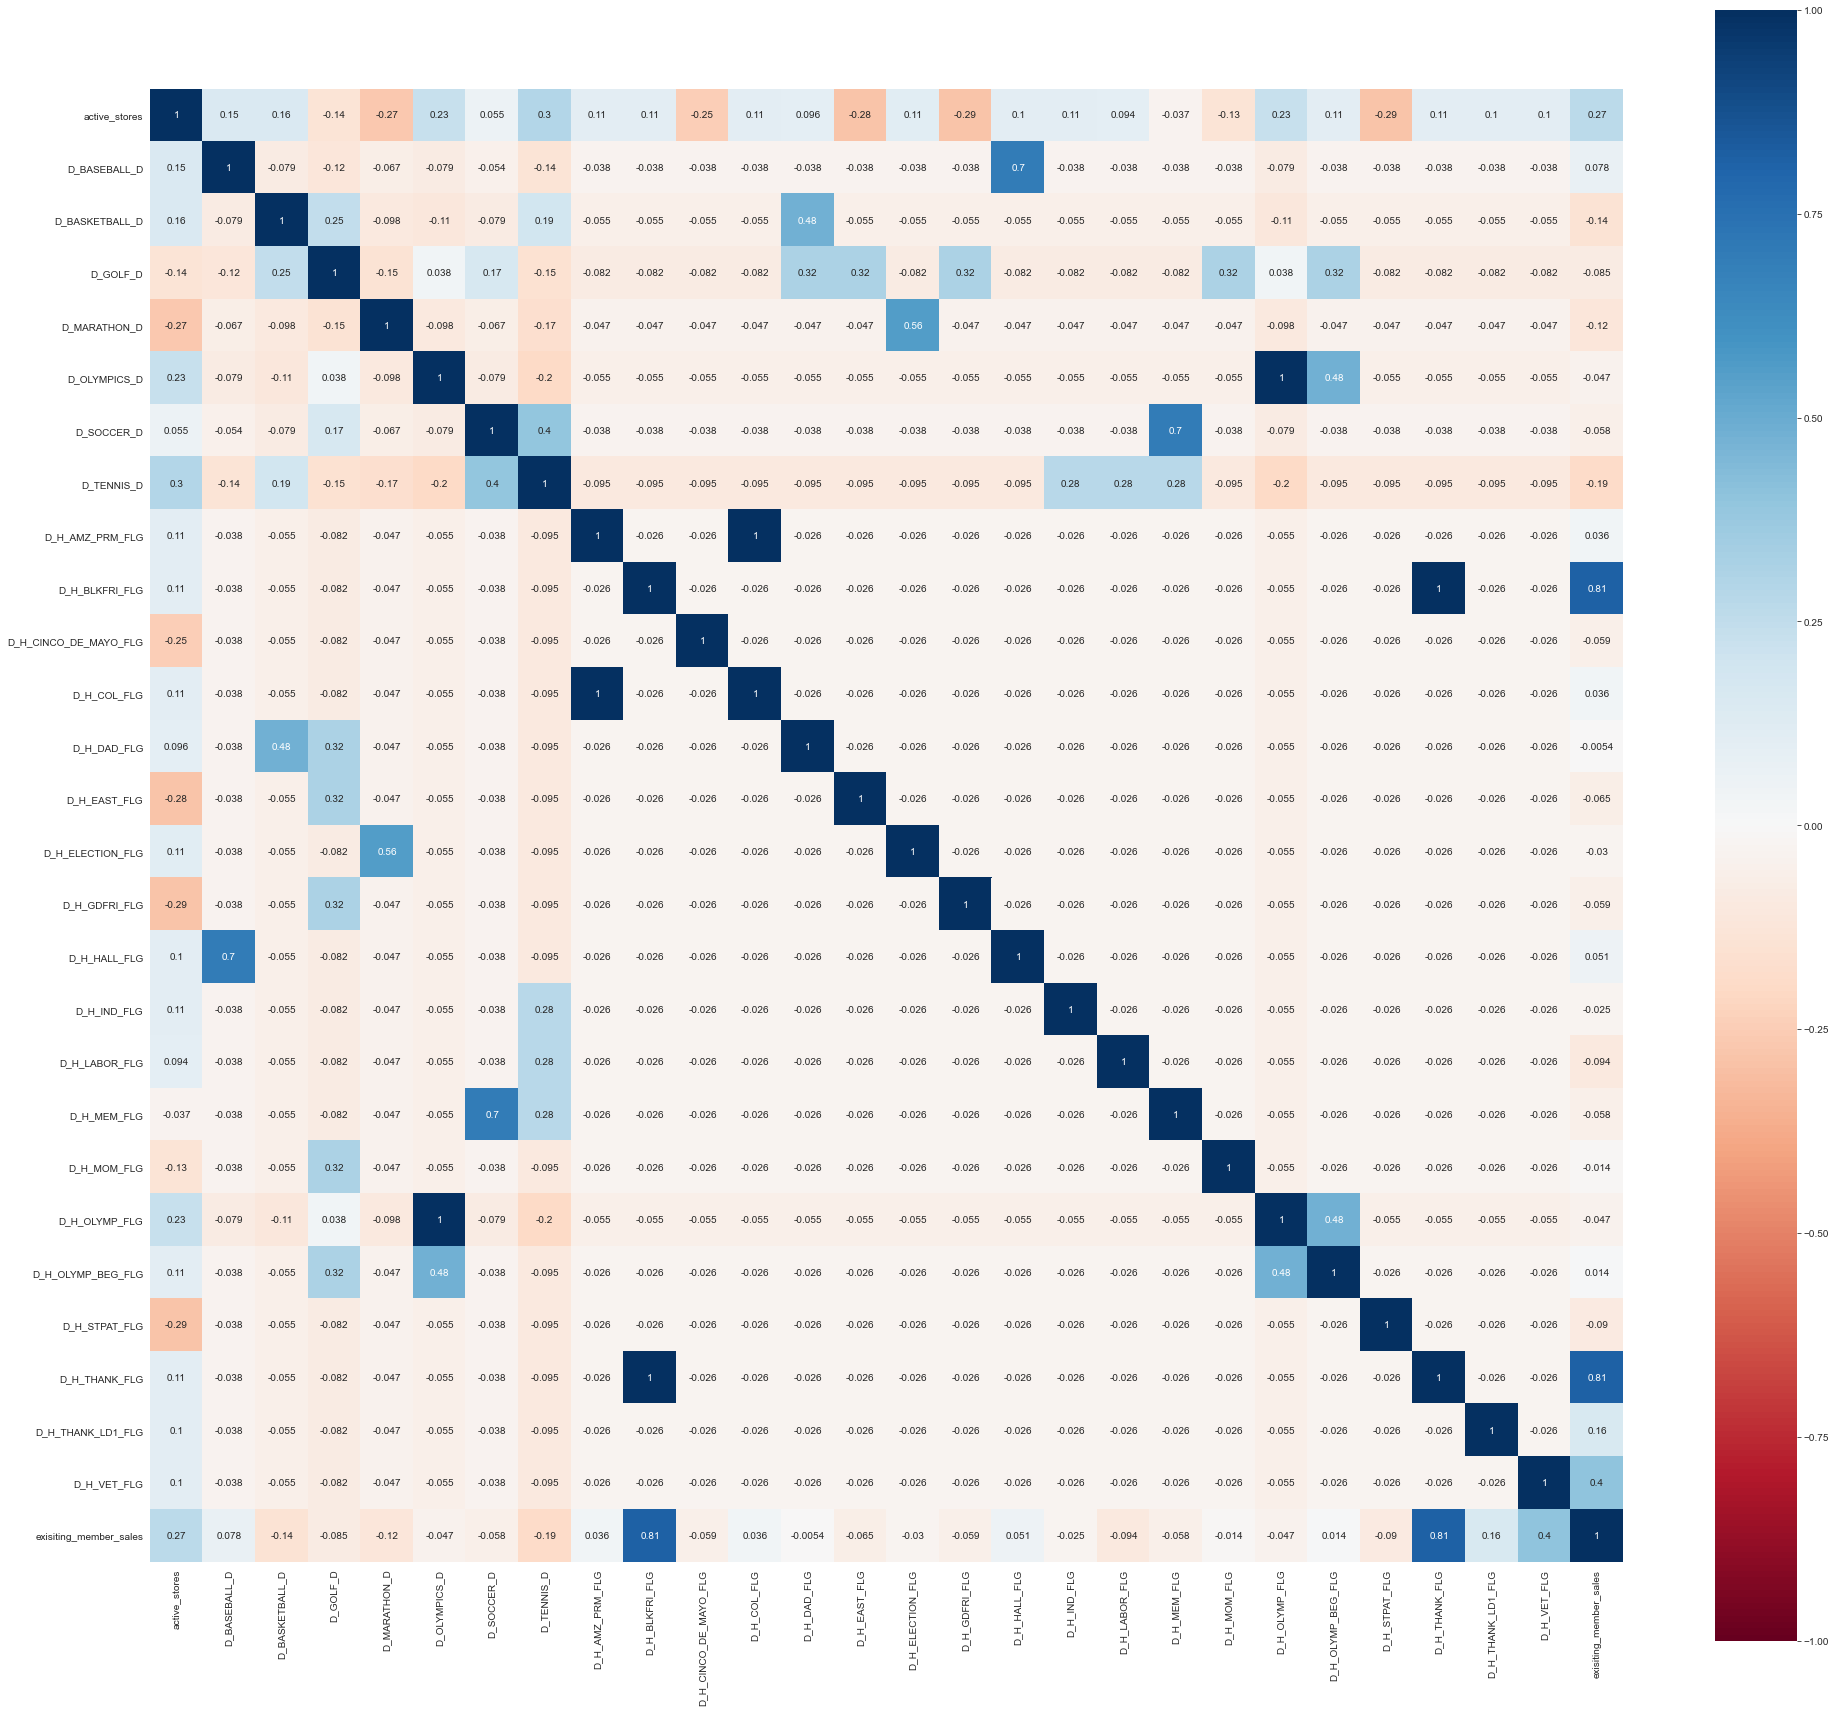

In [7]:
df_correlation = df[positive_vars + [dep_var]].corr()
plt.figure(figsize=(33, 30))
sns.heatmap(df_correlation, square=True, annot=True, vmax=1, vmin=-1, cmap='RdBu')

<Figure size 3600x3600 with 0 Axes>

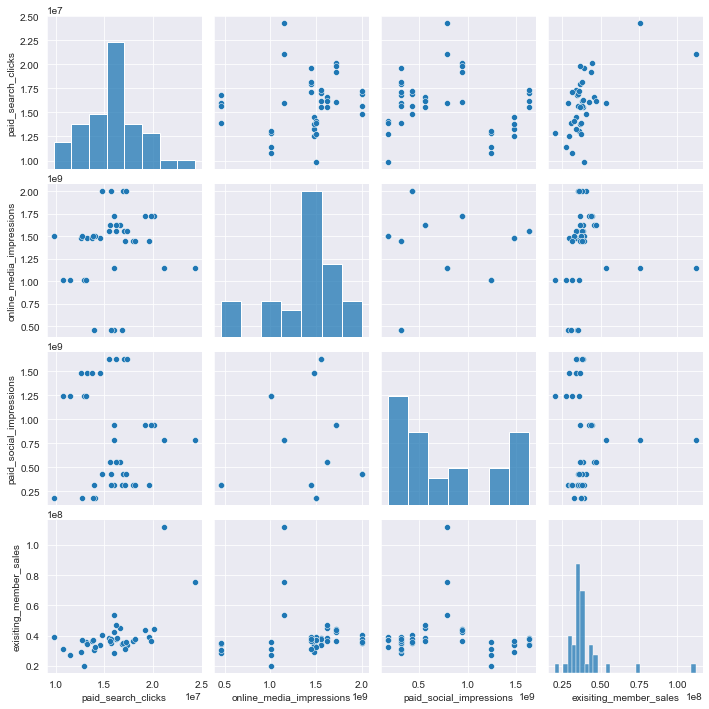

In [8]:
plt.figure(figsize=(50, 50))
sns.pairplot(df[media_vars + [dep_var]], vars=media_vars + [dep_var])

### VARIABLES TRANSFORMATION

##### Diminishing Return

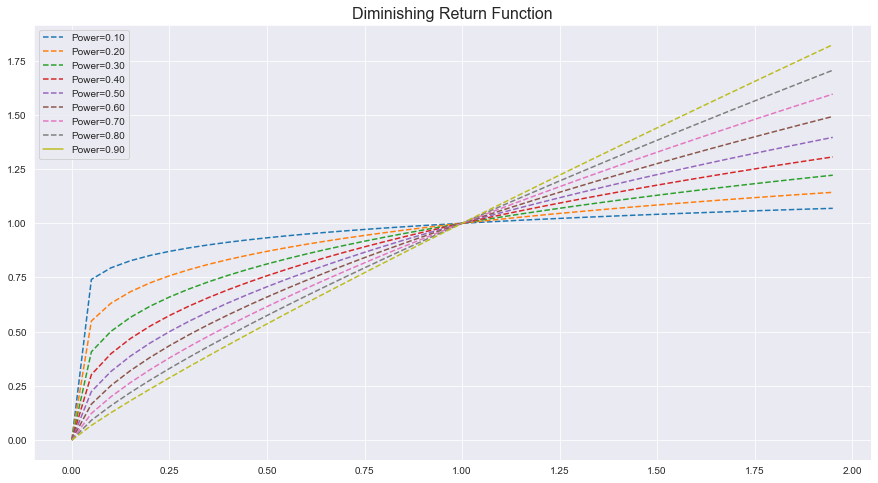

In [9]:
bmmm.plot_transformation()

##### Ad Stock / Carry Over

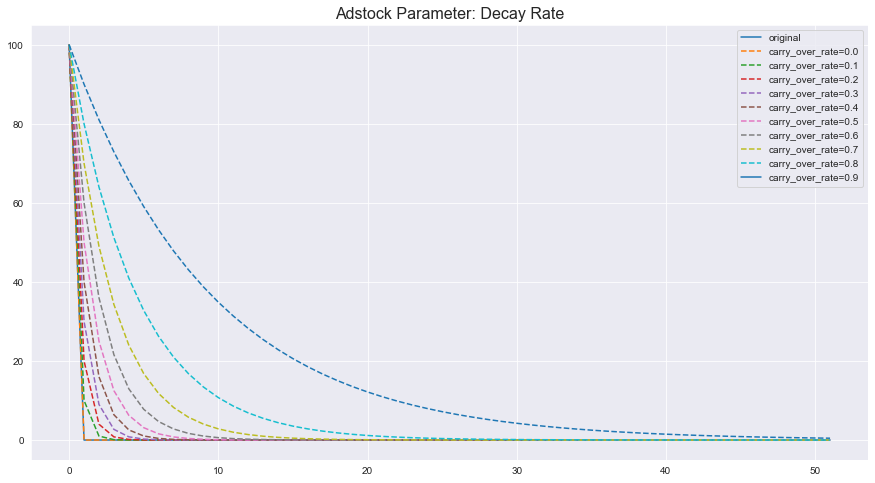

In [10]:
bmmm.plot_adstock()

### MODEL - BAYESIAN LINEAR REGRESSION

##### Mean Centering

In [11]:
def get_model_data_set(df, dep_var, media_vars, comp_media_vars, positive_vars, neutral_vars, negative_vars, model_form):
    
    if model_form.lower() == 'linear':
        df_model, scale_model = bmmm.apply_mean_center(df, [dep_var] + [v for v in positive_vars if v[0:2] != 'D_'] + negative_vars)
        df_model = pd.concat([df[media_vars], df[comp_media_vars], df_model, df[[v for v in positive_vars if v[0:2] == 'D_']], df[neutral_vars]], axis=1)
    elif model_form.lower() == 'log-log':
                df_model, scale_model = bmmm.apply_mean_log(df, [v for v in positive_vars if v[0:2] != 'D_'] + negative_vars)
#         df_model, scale_model = bmmm.apply_mean_log(df, [dep_var] + [v for v in positive_vars if v[0:2] != 'D_'] + negative_vars)
        df_model = pd.concat([df[dep_var], df[media_vars], df[comp_media_vars], df_model, df[[v for v in positive_vars if v[0:2] == 'D_']], df[neutral_vars]], axis=1)
        df_model[dep_var] = df_model[dep_var]/df_model[dep_var].mean() # demean dep_var (don't take log)
#         df_model = pd.concat([df[media_vars], df[comp_media_vars], df_model, df[[v for v in positive_vars if v[0:2] == 'D_']], df[neutral_vars]], axis=1)
    df_model[dep_var + '_raw'] = df[dep_var]
    df_model.index = df.index
    df_model['CrossSection'] = df[cross_section_col].values if cross_section_col is not None else 'ALL'
    df_model['CrossSectionIndex'] = df_model.groupby(['CrossSection']).ngroup()
    df_model['Date'] = df[date_col].astype('datetime64[ns]')
    df_model['DateIndex'] = df_model.groupby(['Date']).ngroup()    
    df_model['RowIndex'] = [i for i in range(len(df_model))]
    df_model = df_model[['CrossSection', 'Date', 'CrossSectionIndex', 'DateIndex'] + [col for col in df_model if col not in ['CrossSection', 'Date', 'CrossSectionIndex', 'DateIndex']]]
    
    return df_model, scale_model

df_model, scale_model = get_model_data_set(df, dep_var, media_vars, comp_media_vars, positive_vars, neutral_vars, negative_vars, model_form)

# Media Variables
X_media = df_model[media_vars].values
X_comp_media = df_model[comp_media_vars].values

# Control Variables
X_control_positive = df_model[positive_vars].values
X_control_neutral = df_model[neutral_vars].values
X_control_negative = df_model[negative_vars].values

##### Bayesian Model Definition

In [12]:
model_data = {
    'N': len(df_model),
    'y': df_model[dep_var].values,
    'X_media': X_media,
    'X_comp_media': X_comp_media,
    'X_control_positive': X_control_positive,
    'X_control_neutral': X_control_neutral,
    'X_control_negative': X_control_negative,
    'num_media': len(media_vars),
    'num_comp_media': len(comp_media_vars),
    'num_control_positive': len(positive_vars),
    'num_control_neutral': len(neutral_vars),
    'num_control_negative': len(negative_vars),
    # 'max_intercept': min(df_model[dep_var]),
}


model_code = """
functions {
    // the diminishing function
    real apply_diminishing(real t, real alpha) {    
        return t^alpha;
    }
    // mean 
    real calc_mean(vector t) {
        return mean(t);
    }
}
data {
    int N; // number of observations
    int num_media; // number of media variables
    int num_comp_media; // number of competitive media variables
    int num_control_positive; // number of positive control variables
    int num_control_neutral; // number of neutral control variables
    int num_control_negative; // number of negative control variables
    // real max_intercept; // restrict the intercept to be less than the minimum y
    vector[N] y;
    matrix[N, num_media] X_media;
    matrix[N, num_comp_media] X_comp_media;
    matrix[N, num_control_positive] X_control_positive;
    matrix[N, num_control_neutral] X_control_neutral;
    matrix[N, num_control_negative] X_control_negative;
}
parameters {
    real<lower=0> tau; // intercept
    vector<lower=0>[num_control_positive] beta1; // regression coefficients for X_control_positive
    vector[num_control_neutral] beta2; // regression coefficients for X_control_neutral    
    vector<upper=0>[num_control_negative] beta3; // regression coefficients for X_control_negative    
    vector<lower=0>[num_media] beta;  // the coefficients for media variables - half normal    
    vector<lower=0.1, upper=0.9>[num_media] alpha;  // the alpha parameter for the diminishing transformation of each media
    vector<lower=0.1, upper=0.9>[num_media] decay;  // the decay parameter for the adstock transformation of each media
    vector<upper=0>[num_comp_media] beta_comp;  // the coefficients for comp media variables - half normal
    vector<lower=0.1, upper=0.9>[num_comp_media] alpha_comp;  // the alpha parameter for the diminishing transformation of each comp media
    vector<lower=0.1, upper=0.9>[num_comp_media] decay_comp;  // the decay parameter for the adstock transformation of each comp media  
    real<lower=0> noise_var; // residual variance
}
transformed parameters {    
    matrix[N, num_media] X_media_transformed;  // matrix of media variables after transformation
    matrix[N, num_comp_media] X_comp_media_transformed;  // matrix of comp media variables after transformation          
    real tmp_mean;
    
    // apply diminishing, adstock, mean-center        
    for (media in 1:num_media) {
        for (nn in 1:N) {                           
            if (nn == 1) {                
                X_media_transformed[nn, media] = apply_diminishing(X_media[nn, media], alpha[media]);                                                                                               
            } else {
                X_media_transformed[nn, media] = apply_diminishing(X_media[nn, media], alpha[media]) + X_media_transformed[(nn - 1), media] * (1 - decay[media]);                                                                          
            } 
        }
        tmp_mean = calc_mean(col(X_media_transformed, media));
        for (nn in 1:N) {
            X_media_transformed[nn, media] = X_media_transformed[nn, media] / tmp_mean; // Semi-log model
            // X_media_transformed[nn, media] = log1p(X_media_transformed[nn, media] / tmp_mean);  // For log-log model
        }
    }    
    for (media in 1:num_comp_media) {
        for (nn in 1:N) {                           
            if (nn == 1) {                
                X_comp_media_transformed[nn, media] = apply_diminishing(X_comp_media[nn, media], alpha_comp[media]);                                                                                               
            } else {
                X_comp_media_transformed[nn, media] = apply_diminishing(X_comp_media[nn, media], alpha_comp[media]) + X_comp_media_transformed[(nn - 1), media] * (1 - decay_comp[media]);                                                                          
            } 
        }
        tmp_mean = calc_mean(col(X_comp_media_transformed, media));
        for (nn in 1:N) {
            X_comp_media_transformed[nn, media] = X_comp_media_transformed[nn, media] / tmp_mean; // Semi-log model
            // X_comp_media_transformed[nn, media] = log1p(X_comp_media_transformed[nn, media] / tmp_mean);  // For log-log model
        }      
    }    
}
model {
    alpha ~ beta(3, 3);
    decay ~ beta(3, 3);
    alpha_comp ~ beta(3, 3);
    decay_comp ~ beta(3, 3);
    tau ~ normal(0, 5);
    for (i in 1:num_media) {
        beta[i] ~ normal(0, 1);
    }
    for (i in 1:num_comp_media) {
        beta_comp[i] ~ normal(0, 1);
    }
    beta1 ~ normal(0, 1); 
    beta2 ~ normal(0, 1);
    beta3 ~ normal(0, 1); 
    noise_var ~ inv_gamma(0.05, 0.05 * 0.01);
    y ~ lognormal(tau + X_media_transformed * beta + X_comp_media_transformed * beta_comp + X_control_positive * beta1 + X_control_neutral * beta2 + X_control_negative * beta3, sqrt(noise_var));
}
generated quantities {
    real predicted_y[N] = lognormal_rng(tau + X_media_transformed * beta + X_comp_media_transformed * beta_comp + X_control_positive * beta1 + X_control_neutral * beta2 + X_control_negative * beta3, sqrt(noise_var));
}
"""

# Compile model
stan_mmm_model = pystan.StanModel(model_code=model_code, verbose=True)
mmm_model_fit = stan_mmm_model.sampling(data=model_data, iter=1000, chains=5, control=dict(max_treedepth=20))

# Save model
bmmm.save_pickle(stan_mmm_model, my_path + 'models/' + model_name + '/mmm_def.pkl')
bmmm.save_pickle(mmm_model_fit, my_path + 'models/' + model_name + '/mmm_fit.pkl')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d1811bb34d7c3082a77c759bf9fdad53 NOW.
INFO:pystan:OS: win32, Python: 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)], Cython 0.29.23


Compiling C:\Users\NAM~1.TRA\AppData\Local\Temp\pystan_i1eb3vth\stanfit4anon_model_d1811bb34d7c3082a77c759bf9fdad53_2235323182450273659.pyx because it changed.
[1/1] Cythonizing C:\Users\NAM~1.TRA\AppData\Local\Temp\pystan_i1eb3vth\stanfit4anon_model_d1811bb34d7c3082a77c759bf9fdad53_2235323182450273659.pyx
building 'stanfit4anon_model_d1811bb34d7c3082a77c759bf9fdad53_2235323182450273659' extension
C:\ProgramData\Anaconda3\Library\mingw-w64\bin\gcc.exe -mdll -O -Wall -DMS_WIN64 -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -IC:\Users\NAM~1.TRA\AppData\Local\Temp\pystan_i1eb3vth -IC:\ProgramData\Anaconda3\lib\site-packages\pystan -IC:\ProgramData\Anaconda3\lib\site-packages\pystan\stan\src -IC:\ProgramData\Anaconda3\lib\site-packages\pystan\stan\lib\stan_math -IC:\ProgramData\Anaconda3\lib\site-packages\pystan\stan\lib\stan_math\lib\eigen_3.3.3 -IC:\ProgramData\Anaconda3\lib\site-packages\pystan\stan\lib\stan_math\lib\boost_1.69.0 -IC:\ProgramData\Anaconda3\lib\si

In [13]:
stan_mmm_model = bmmm.load_pickle(my_path + 'models/' + model_name + '/mmm_def.pkl')
mmm_model_fit = bmmm.load_pickle(my_path + 'models/' + model_name + '/mmm_fit.pkl')
mmm_model_fit_result = mmm_model_fit.extract()
print(pystan.stansummary(fit=mmm_model_fit, probs=(0.025, 0.975), digits_summary=2))

Inference for Stan model: anon_model_d1811bb34d7c3082a77c759bf9fdad53.
5 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2500.

                                  mean se_mean     sd   2.5%   97.5%  n_eff   Rhat
tau                               2.02    0.03   1.13    0.2    4.54   1432    1.0
beta1[1]                          0.28  4.8e-3   0.21   0.01    0.82   1977    1.0
beta1[2]                          0.35  6.9e-3   0.27 9.1e-3     1.0   1520    1.0
beta1[3]                          0.62    0.01   0.46   0.03    1.72   2154    1.0
beta1[4]                          0.26  3.4e-3   0.16   0.02    0.63   2240    1.0
beta1[5]                          0.37  4.8e-3   0.21   0.04    0.86   1990    1.0
beta1[6]                          0.17  3.1e-3   0.15 7.0e-3    0.58   2366    1.0
beta1[7]                          0.39  6.6e-3   0.27   0.01    1.01   1635    1.0
beta1[8]                          0.12  2.4e-3   0.11 3.5e-3    0.

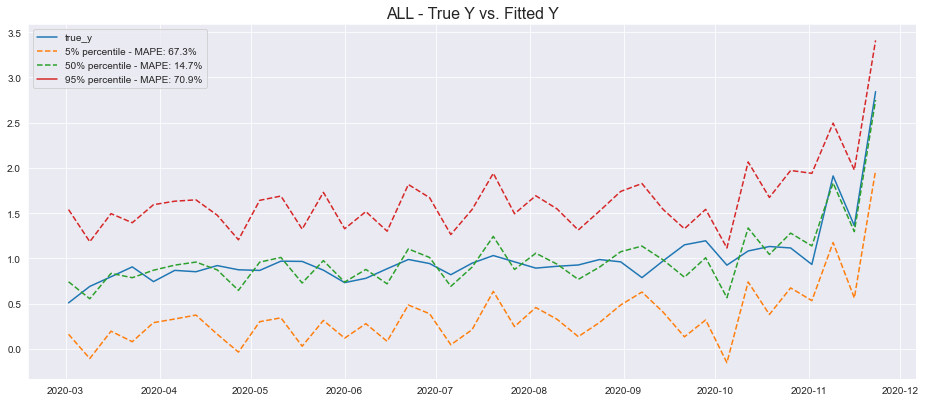

In [14]:
mmm_model_output = bmmm.extract_mmm_model(mmm_model_fit_result, dep_var, media_vars=media_vars, comp_media_vars=comp_media_vars, positive_vars=positive_vars, neutral_vars=neutral_vars, negative_vars=negative_vars)
bmmm.save_pickle(mmm_model_output, my_path + 'models/' + model_name + '/mmm_output.pkl')
bmmm.plot_model_fit(mmm_model_fit_result, true_y=df_model[dep_var].values, x=df_model['Date'].values, percentile_list=[5, 50, 95], x_index=df_model[['CrossSection', 'Date', 'RowIndex']])   

### OUTPUT POSTERIOR DISTRIBUTIONS

In [35]:
simulated_results = bmmm.simulate_mmm_model_prediction(mmm_model_output, df_model, df_media_spend, model_form, min_max_adjustment=True, num_sample=None)
bmmm.save_pickle(simulated_results, my_path + 'models/' + model_name + '/simulated_results.pkl')
simulated_results = bmmm.load_pickle(my_path + 'models/' + model_name + '/simulated_results.pkl')

 > Completed 100 / 2500 sample iterations
 > Completed 200 / 2500 sample iterations
 > Completed 300 / 2500 sample iterations
 > Completed 400 / 2500 sample iterations
 > Completed 500 / 2500 sample iterations
 > Completed 600 / 2500 sample iterations
 > Completed 700 / 2500 sample iterations
 > Completed 800 / 2500 sample iterations
 > Completed 900 / 2500 sample iterations
 > Completed 1000 / 2500 sample iterations
 > Completed 1100 / 2500 sample iterations
 > Completed 1200 / 2500 sample iterations
 > Completed 1300 / 2500 sample iterations
 > Completed 1400 / 2500 sample iterations
 > Completed 1500 / 2500 sample iterations
 > Completed 1600 / 2500 sample iterations
 > Completed 1700 / 2500 sample iterations
 > Completed 1800 / 2500 sample iterations
 > Completed 1900 / 2500 sample iterations
 > Completed 2000 / 2500 sample iterations
 > Completed 2100 / 2500 sample iterations
 > Completed 2200 / 2500 sample iterations
 > Completed 2300 / 2500 sample iterations
 > Completed 2400 / 

In [36]:
confidence = 0.95
selected_model_index, selected_sample_counter = bmmm.select_model(simulated_results, metric='MAPE_SOSSOC', alpha=1-confidence)
# selected_model_index = 1649
# selected_sample_counter = next((c for c, i in enumerate(simulated_results['ModelIndex']) if i == selected_model_index), None)
my_fig = bmmm.plot_model_stats(simulated_results, x='MAPE', y='SOSSOC', metric='MAPE_SOSSOC', selected_model_index=selected_model_index, alpha=1-confidence)

Selected Model Index: 850 - MAPE_SOSSOC: 0.6199164889362989


##### Coefficients & Transformation Parameters Posterior Distribution

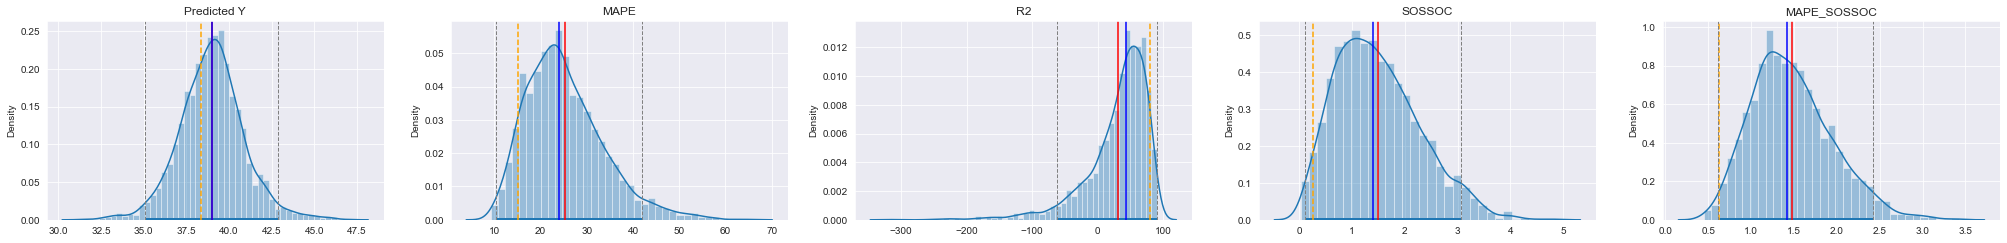

In [37]:
bmmm.plot_model_output_distribution(params=simulated_results['ModelStats'], selected_model_index=selected_sample_counter, alpha=1-confidence)

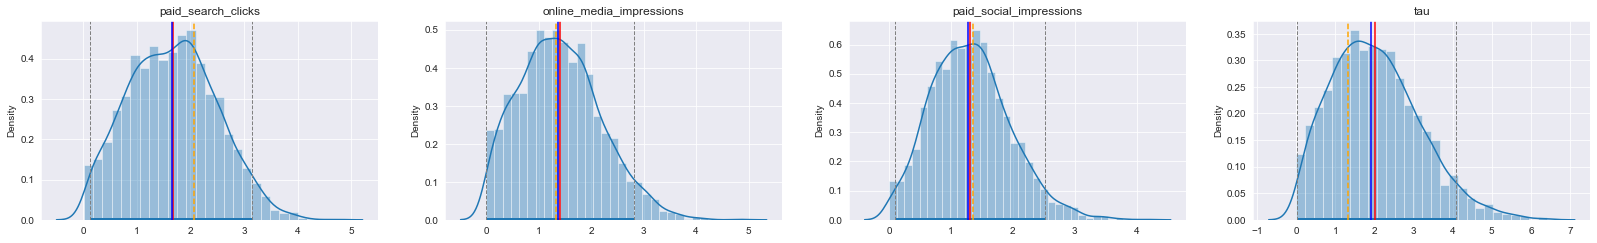

In [38]:
bmmm.plot_posterior_distribution(variables=media_vars, params=mmm_model_output, para_name='beta', selected_model_index=selected_model_index, alpha=1-confidence)

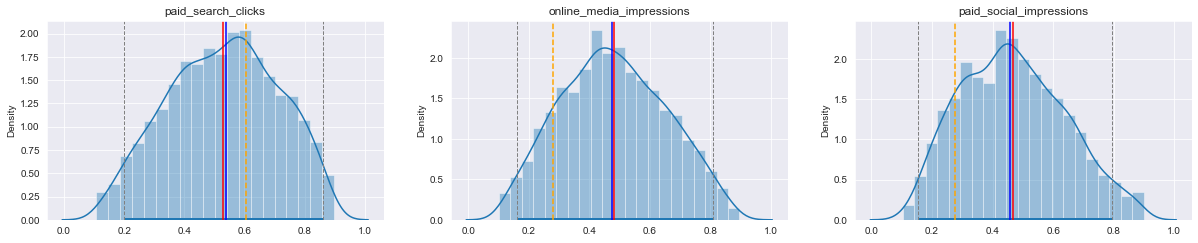

In [39]:
bmmm.plot_posterior_distribution(variables=media_vars, params=mmm_model_output, para_name='alpha', selected_model_index=selected_model_index, alpha=1-confidence)

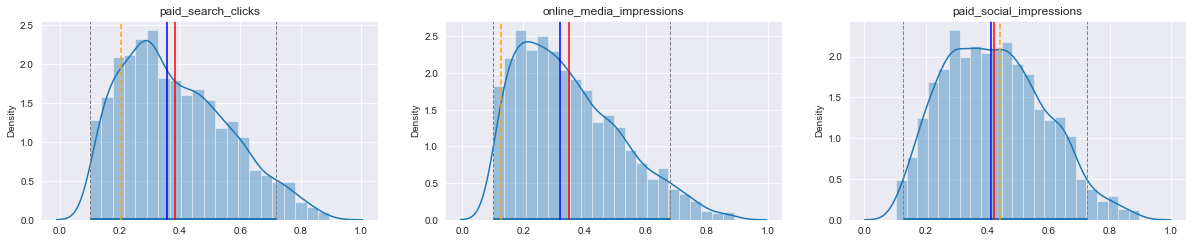

In [40]:
bmmm.plot_posterior_distribution(variables=media_vars, params=mmm_model_output, para_name='decay', selected_model_index=selected_model_index, alpha=1-confidence)

##### Model Outputs Posterior Distribution

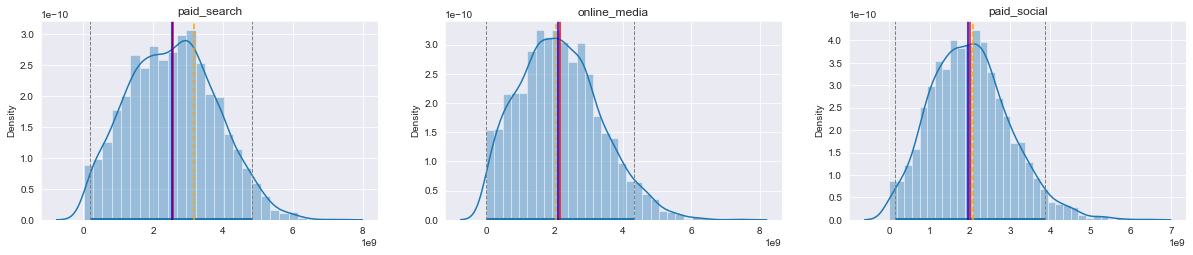

In [41]:
bmmm.plot_model_output_distribution(params=simulated_results['ModelContributions'], selected_model_index=selected_sample_counter, alpha=1-confidence)

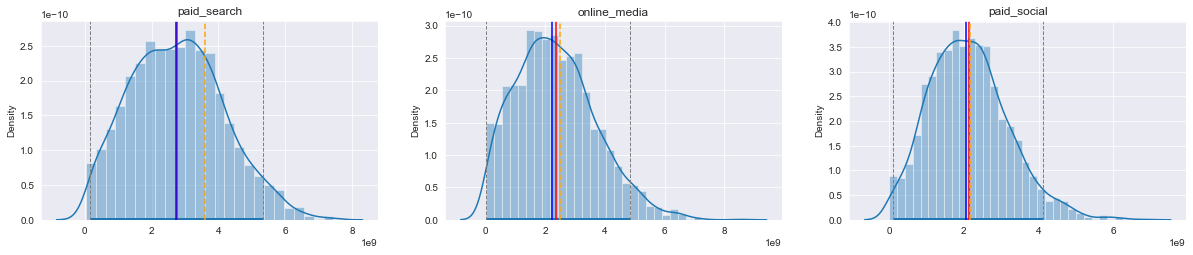

In [42]:
bmmm.plot_model_output_distribution(params=simulated_results['LifeTimeContributions'], selected_model_index=selected_sample_counter, alpha=1-confidence)

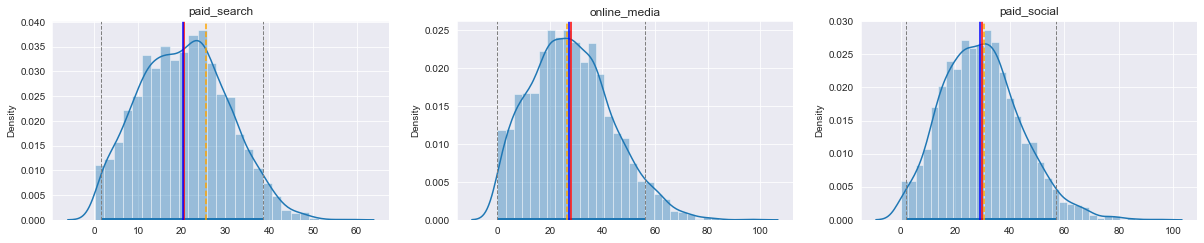

In [43]:
bmmm.plot_model_output_distribution(params=simulated_results['ROAS'], selected_model_index=selected_sample_counter, alpha=1-confidence)

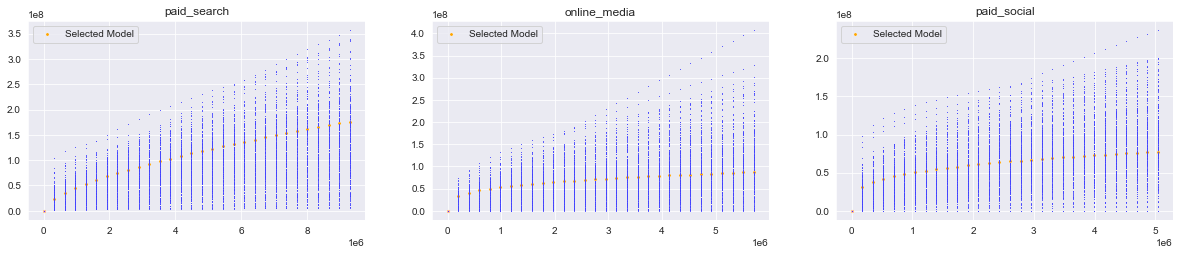

In [44]:
bmmm.plot_response_curves(params=simulated_results['ResponseCurves'], selected_model_index=selected_sample_counter)

### MODEL CONTRIBUTIONS

In [45]:
df_contributions, df_lifetime_contributions, df_model_specifications = bmmm.calc_model_contributions(df, df_model, mmm_model_output, df_media_spend, selected_model_index, model_form, min_max_adjustment=True)
my_fig = bmmm.plot_model_actual_vs_predicted(df_contributions, mmm_model_output)

MAPE: 15.0% - R2: 79.8%


In [46]:
my_fig = bmmm.plot_model_contributions(df_contributions, mmm_model_output)
# my_fig = bmmm.plot_model_decomposition(df_contributions, mmm_model_output, media_only=True)

In [47]:
dict_decomposition = bmmm.calc_model_decomposition(df, df_model, mmm_model_output, df_media_spend, selected_model_index, model_form, num_weeks=None, min_max_adjustment=True)
my_fig = bmmm.plot_share_of_spend_vs_contributions(dict_decomposition)

In [48]:
my_fig = bmmm.plot_waterfall(dict_decomposition)

In [49]:
my_fig = bmmm.plot_contributions_vs_roas(dict_decomposition)

In [50]:
my_fig = bmmm.plot_spend_vs_roas(dict_decomposition)

### EXPORT

In [51]:
df_model_contributions, df_model_specifications, df_melted = bmmm.export_model_output(mmm_model_output, df, df_model, model_params, selected_model_index=selected_model_index)
output = {
    'AnalyticalFile': df, 
    'Data': df_melted, 
    'ModelContributions': df_model_contributions, 
    'ModelSpecifications': df_model_specifications
}
bmmm.write_excel(output, my_path + 'data/' + model_name + '_output.xlsx')

MAPE: 15.0% - R2: 79.8%
 - Writing AnalyticalFile sheet data. 39 Rows & 1160 columns
 - Writing Data sheet data. 2418 Rows & 6 columns
 - Writing ModelContributions sheet data. 2301 Rows & 7 columns
 - Writing ModelSpecifications sheet data. 60 Rows & 7 columns


In [52]:
bmmm.beauty_display(df_model_specifications)

,CrossSection,Variable,DiminishingFunction,DiminishingRate,DecayFunction,DecayRate,Coefficient
0,[TOTAL],paid_search_clicks,power,0.606384,geometric,0.203111,806.331443
1,[TOTAL],online_media_impressions,power,0.280765,geometric,0.126246,22071.629287
2,[TOTAL],paid_social_impressions,power,0.274992,geometric,0.441520,91433.974453
3,[TOTAL],adidas_impressions,linear,1.000000,geometric,1.000000,-25.363291
4,[TOTAL],vans_impressions,linear,1.000000,geometric,1.000000,-6.953506


In [53]:
bmmm.beauty_display(df_model_contributions)

,Date,Channel,Variable,Impressions,Spend,ModelContribution,LifeTimeContribution
0,2020-03-02 00:00:00,paid_search,paid_search_clicks,12890258.000000,2336114.500000,16522082.982079,81344975.685410
1,2020-03-09 00:00:00,paid_search,paid_search_clicks,11454613.000000,2332476.100000,28546698.906019,75724187.887387
2,2020-03-16 00:00:00,paid_search,paid_search_clicks,10739768.000000,2155449.300000,37539581.947108,72822342.183722
3,2020-03-23 00:00:00,paid_search,paid_search_clicks,13099653.000000,2933302.500000,46599184.249277,82143711.449956
4,2020-03-30 00:00:00,paid_search,paid_search_clicks,12572395.000000,2382468.800000,53408180.294034,80122658.154083


In [54]:
bmmm.beauty_display(df_melted)

,date,Variable,Quantity,Channel,VariableCategory,Spend
0,2020-03-02 00:00:00,paid_search_clicks,12890258.000000,paid_search,quantity,0.000000
1,2020-03-09 00:00:00,paid_search_clicks,11454613.000000,paid_search,quantity,0.000000
2,2020-03-16 00:00:00,paid_search_clicks,10739768.000000,paid_search,quantity,0.000000
3,2020-03-23 00:00:00,paid_search_clicks,13099653.000000,paid_search,quantity,0.000000
4,2020-03-30 00:00:00,paid_search_clicks,12572395.000000,paid_search,quantity,0.000000
